In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [3]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
# load data from grads notebook! 
def load_dataset(path="/n/home12/isanchez/jaxneuro/outputs/local_phys_dataset.npz"):
    d = np.load(path)
    out = {k: d[k] for k in d.files}
    for k in ("dt", "t_max", "i_delay", "i_dur", "N_trials", "Nsyn"):
        if k in out:
            out[k] = float(out[k]) if "." in str(out[k]) else int(out[k])
    return out

ds = load_dataset()

GRADS = ds["GRADS"]  # (N, Nsyn)
VLOCAL = ds["VLOCAL"]  # (N, Nsyn -1, T)
VSOMA = ds["VSOMA"]   # (N, T)
VALL = ds["VALL"]  # (N, Nsyn, T)
patterns = ds["patterns"] # (N, Nsyn)
losses = ds["losses"]  # (N,)
syn_post_comp_indices = ds["syn_post_comp_indices"]

dt = ds["dt"]
t_max = ds["t_max"]
i_delay = ds["i_delay"]
i_dur = ds["i_dur"]

N, Nsyn = GRADS.shape
T = VALL.shape[2]

# time axis
t = np.arange(T) * dt  # (T,)

# stimulus boolean mask
t_stim = (t >= i_delay) & (t <= i_delay + i_dur)


print(f"GRADS: {GRADS.shape}")
print(f"VLOCAL: {VLOCAL.shape}")
print(f"VSOMA: {VSOMA.shape}")
print(f"VALL: {VALL.shape}")
print(f"patterns:{patterns.shape}")
print(f"losses: {losses.shape}")
print(f"\n dt={dt} ms, t_max={t_max} ms,T={T} timepoints")
print(f"i_delay={i_delay} ms,i_dur={i_dur} ms")
print(f"stimulus window: {t_stim.sum()} timepoints "
      f"({t[t_stim][0]:.3f}–{t[t_stim][-1]:.3f} ms)")
print(f" N_trials={N},  Nsyn={Nsyn}")
print(f"syn_post_comp_indices = {syn_post_comp_indices}")

assert GRADS.shape == (N, Nsyn)
assert VLOCAL.shape == (N, Nsyn -1, T)
assert VSOMA.shape  == (N, T)
assert VALL.shape == (N, Nsyn, T)
print("\nAll shape checks passed!!!")


GRADS: (500, 8)
VLOCAL: (500, 7, 2002)
VSOMA: (500, 2002)
VALL: (500, 8, 2002)
patterns:(500, 8)
losses: (500,)

 dt=0.025 ms, t_max=50.0 ms,T=2002 timepoints
i_delay=3.0 ms,i_dur=2.0 ms
stimulus window: 81 timepoints (3.000–5.000 ms)
 N_trials=500,  Nsyn=8
syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]

All shape checks passed!!!


## Step 7a: time correlation map

At each timepoint t and for each synapse, we can compute the Pearson correlation (across trials n) between a local signal $x_{n,i}(t)$ and the scalar gradient $g_{n,i}$ so that we have 

$$r_i(t) = \text{corr}_n\!\big(x_{n,i}(t),\; g_{n,i}\big)$$

and then aggregate $\overline{r^2}(t) = \text{mean}_i\, r_i(t)^2$


Becuase I have v_soma and v_local, I can compute the correlation with the gradient of v_local. And separetly do v_soma? Or does it make more sense to do all at once? 

In [5]:
def time_resolved_corr(signal, grads):
    N, Nsyn, T = signal.shape
    assert grads.shape == (N, Nsyn), f"Expected grads {(N, Nsyn)}, got {grads.shape}"

    r_by_syn = np.zeros((Nsyn, T))
    for i in range(Nsyn):
        g_i = grads[:, i] # in R^N
        # vectorised pearson r across all timepoints at once
        # signal[:, i, :] is (N, T) — correlate each column with g_i
        x = signal[:, i, :]  # in R^N
        # demean
        x_dm = x - x.mean(axis=0, keepdims=True)
        g_dm = g_i - g_i.mean()
        num = (x_dm * g_dm[:, None]).sum(axis=0)          # (T,)
        denom = np.sqrt((x_dm**2).sum(axis=0) * (g_dm**2).sum()) + 1e-30 # want to prevent division by zero 
        r_by_syn[i] = num / denom # (Nsyn, T)
    return r_by_syn


r_v_all = time_resolved_corr(VALL, GRADS) # (Nsyn, T)
mean_r2_v_all = (r_v_all**2).mean(axis=0)  # (T,)
mean_r_v_all = r_v_all.mean(axis=0) # (T,)


## look at changes in voltage? 
dVdt = np.gradient(VALL, dt, axis=2)  # (N, Nsyn, T)
r_dvdt = time_resolved_corr(dVdt, GRADS)  # (Nsyn, T)
mean_r2_dvdt = (r_dvdt**2).mean(axis=0) # (T,)
mean_r_dvdt = r_dvdt.mean(axis=0) # (T,)

print(f"r_v_all shape: {r_v_all.shape}")
print(f"mean_r2_v_all shape: {mean_r2_v_all.shape}")
print(f"r_dvdt shape: {r_dvdt.shape}")
print(f"mean_r2_dvdt shape: {mean_r2_dvdt.shape}")


r_v_all shape: (8, 2002)
mean_r2_v_all shape: (2002,)
r_dvdt shape: (8, 2002)
mean_r2_dvdt shape: (2002,)


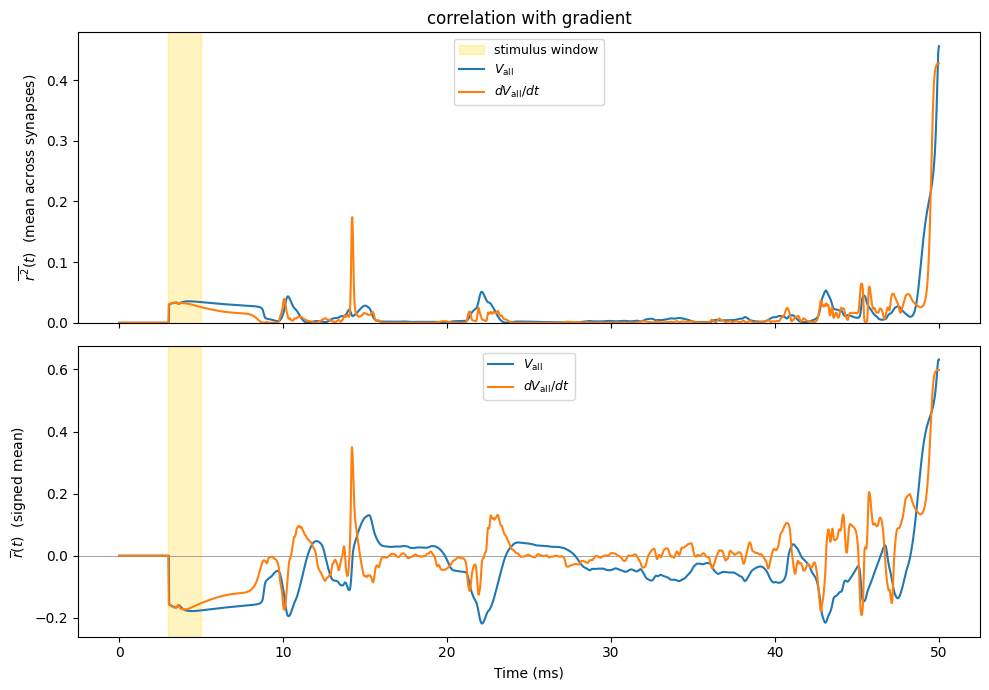

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus window")
ax.plot(t, mean_r2_v_all, label=r"$V_{\rm all}$", lw=1.5)
ax.plot(t, mean_r2_dvdt,   label=r"$dV_{\rm all}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r^2}(t)$  (mean across synapses)")
ax.set_title("correlation with gradient")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
ax.axhline(0, color="grey", lw=0.5)
ax.plot(t, mean_r_v_all, label=r"$V_{\rm all}$", lw=1.5)
ax.plot(t, mean_r_dvdt,   label=r"$dV_{\rm all}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r}(t)$  (signed mean)")
ax.set_xlabel("Time (ms)")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


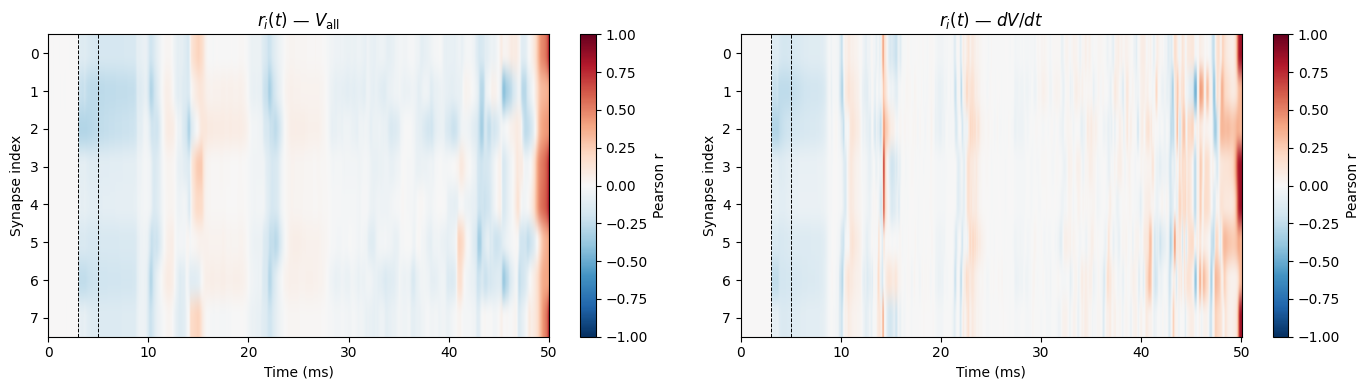

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, data, title in zip(
    axes,
    [r_v_all, r_dvdt],
    [r"$r_i(t)$ — $V_{\rm all}$", r"$r_i(t)$ — $dV/dt$"],
):
    im = ax.imshow(
        data,
        aspect="auto",
        cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, - 0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label="Pearson r")

plt.tight_layout()
plt.show()

In [8]:
save_A = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "analysis_stepA.npz")
np.savez(
    save_A,
    r_v_all=r_v_all,          # (Nsyn, T)
    mean_r2_v_all=mean_r2_v_all,  # (T,)
    mean_r_v_all=mean_r_v_all,
    r_dvdt=r_dvdt,
    mean_r2_dvdt=mean_r2_dvdt,
    mean_r_dvdt=mean_r_dvdt,
    t=t,
)
print(f"✓ Step A saved → {save_A}  ({os.path.getsize(save_A)/1e3:.1f} kB)")


✓ Step A saved → /n/home12/isanchez/jaxneuro/outputs/analysis_stepA.npz  (338.1 kB)


So far just seems to be the case that the strongest possible predictive time is really early like near stimulus onset(or like the initial polarization)

also seems to be something happening later on, but not sure how to quantify? maybe more spiking/bAP? 


synapse specific credits vs global effect? I wonder if this is where you do off vs on diagonals? how to zone inmore to bap times etc

## Step 7b — Conditional correlation (ON vs OFF)

For each synapse $i$ and time $t$:

- pooled (computed above): $r_i(t) = \text{corr}(V_i(t), g_i)$ across all trials
- conditional ON: $r_i^{\text{on}}(t) = \text{corr}(V_i(t), g_i \mid p_i = 1)$
- conditional OFF: $r_i^{\text{off}}(t) = \text{corr}(V_i(t), g_i \mid p_i = 0)$


In [18]:
print("ON/OFF trial counts per synapse") # expect N/2 ON and N/2 OFF trials per synapse
on_counts = patterns.sum(axis=0).astype(int)   # (Nsyn,)
off_counts = N - on_counts
for i in range(Nsyn):
    print(f"synapse {i}: ON = {on_counts[i]:4d}, OFF = {off_counts[i]:4d}")

ON/OFF trial counts per synapse
synapse 0: ON =  238, OFF =  262
synapse 1: ON =  234, OFF =  266
synapse 2: ON =  248, OFF =  252
synapse 3: ON =  268, OFF =  232
synapse 4: ON =  237, OFF =  263
synapse 5: ON =  250, OFF =  250
synapse 6: ON =  237, OFF =  263
synapse 7: ON =  228, OFF =  272


In [ ]:
def corr_1d(x, y, eps=1e-12):
    x = x - x.mean()
    y = y - y.mean()
    denom = np.sqrt((x @ x) * (y @ y)) + eps
    return (x @ y) / denom


def timecorr_conditional(VALL, GRADS, patterns, min_trials=20):
    N, Nsyn, T = VALL.shape
    r_on = np.full((Nsyn, T), np.nan)
    r_off = np.full((Nsyn, T), np.nan)

    for i in range(Nsyn):
        m_on = patterns[:, i].astype(bool)
        m_off = ~m_on

        # ON
        if m_on.sum() >= min_trials:
            y = GRADS[m_on, i]           # (N_on,)
            X = VALL[m_on, i, :]         # (N_on, T)
            # vectorised across time
            X_dm = X - X.mean(axis=0, keepdims=True)
            y_dm = y - y.mean()
            num = (X_dm * y_dm[:, None]).sum(axis=0)                     # (T,)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
            r_on[i] = num / denom

        # OFF
        if m_off.sum() >= min_trials:
            y = GRADS[m_off, i]
            X = VALL[m_off, i, :]
            X_dm = X - X.mean(axis=0, keepdims=True)
            y_dm = y - y.mean()
            num = (X_dm * y_dm[:, None]).sum(axis=0)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
            r_off[i] = num / denom

    return r_on, r_off


# conditional correlation
r_on, r_off = timecorr_conditional(VALL, GRADS, patterns)
print(f"r_on  shape: {r_on.shape},  finite: {np.isfinite(r_on).sum()}/{r_on.size}")
print(f"r_off shape: {r_off.shape},  finite: {np.isfinite(r_off).sum()}/{r_off.size}")

# also do dV/dt
r_on_dvdt, r_off_dvdt = timecorr_conditional(dVdt, GRADS, patterns)
print(f"r_on_dvdt  shape: {r_on_dvdt.shape}")
print(f"r_off_dvdt shape: {r_off_dvdt.shape}")


r_on  shape: (8, 2002),  finite: 16016/16016
r_off shape: (8, 2002),  finite: 16016/16016
r_on_dvdt  shape: (8, 2002)
r_off_dvdt shape: (8, 2002)


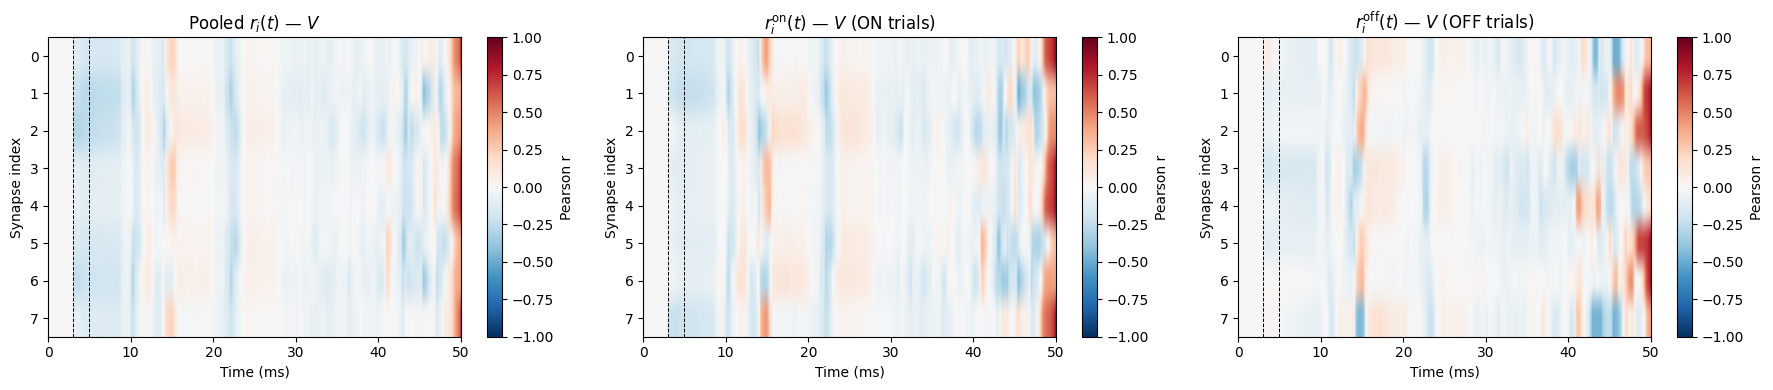

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, data, title in zip(
    axes,
    [r_v_all, r_on, r_off],
    [r"Pooled $r_i(t)$ — $V$",
     r"$r_i^{\mathrm{on}}(t)$ — $V$ (ON trials)",
     r"$r_i^{\mathrm{off}}(t)$ — $V$ (OFF trials)"],
):
    im = ax.imshow(
        data, aspect="auto", cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, -0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label="Pearson r")

plt.tight_layout()
plt.show()


This may be a sign of global effects dominating. We are getting high r at 45ish ms even in the OFF condition. So it may be that the voltage at many sites/synapses is dominated by a shared postsynaptic event (spike/bAP/?) and the g_i covaries with these events because the loss is based on the somatic trace only. Also, the heatmaps look like vertical bands (similar timing across synapses) rather than very synapse specific timing so again hinting at some global effect.

We can check if g_i is actually varying in OFF trials. If gradients are near constant in OFF and we are correlating against tiny variance, correlations can become unstable. We can look at STD, if STDN grad OFF is non trivial, the OFF signal might be real (resynaptic OFF neurons still spike sometimes, or synapse i still has some effect). If it’s tiny, we have to treat OFF correlations with care and think about global effects. 

In [ ]:
for i in range(8):
    m_on = patterns[:, i].astype(bool)
    m_off = ~m_on
    print(i,
          "std grad ON", GRADS[m_on, i].std(),
          "std grad OFF", GRADS[m_off, i].std(),
          "mean|grad| ON", np.mean(np.abs(GRADS[m_on, i])),
          "mean|grad| OFF", np.mean(np.abs(GRADS[m_off, i])))


0 std grad ON 123925310.585579 std grad OFF 12371969.582639663 mean|grad| ON 53257047.79541762 mean|grad| OFF 5625900.726955002
1 std grad ON 65820519.6014641 std grad OFF 24161715.184579004 mean|grad| ON 35274160.95402039 mean|grad| OFF 8808167.55826528
2 std grad ON 63610569.307923645 std grad OFF 24106738.584136855 mean|grad| ON 37148473.987660974 mean|grad| OFF 8044606.177878606
3 std grad ON 115436772.28249194 std grad OFF 11555579.805786442 mean|grad| ON 48969993.799677074 mean|grad| OFF 4795760.714473811
4 std grad ON 121350699.1643392 std grad OFF 11430592.336558167 mean|grad| ON 49762521.58002957 mean|grad| OFF 5223929.198932711
5 std grad ON 62394801.8391758 std grad OFF 24539207.570221964 mean|grad| ON 31811142.334054567 mean|grad| OFF 8900845.12846147
6 std grad ON 67647870.76997787 std grad OFF 23747874.91382532 mean|grad| ON 37929487.806212075 mean|grad| OFF 7915255.1537245605
7 std grad ON 125980940.14709029 std grad OFF 12124021.151390838 mean|grad| ON 52604234.70937053

In [22]:
for i in range(8):
    m_off = ~patterns[:, i].astype(bool)
    vals = np.abs(GRADS[m_off, i])
    print(i, np.percentile(vals, [50, 90, 99]))


0 [  980652.7306756  16013196.69407726 63862925.9292368 ]
1 [2.03339281e+06 1.95137332e+07 1.54063558e+08]
2 [1.39380167e+06 1.40932537e+07 1.53511257e+08]
3 [  674705.95239585 15199238.66884869 55010661.17663208]
4 [  953453.62403185 15971749.56160985 52657533.23101526]
5 [1.91881805e+06 1.90739453e+07 1.53185318e+08]
6 [1.59593996e+06 1.83967978e+07 1.53599196e+08]
7 [ 1289820.05270034 15929316.58022081 52155874.2032307 ]


## Part 7C — Partial correlation controlling for the pattern

For each synapse $i$, time $t$:
1. Regress gradient out of patterns: $g_i \approx \beta^\top P$
2. Regress voltage out of patterns: $V_i(t) \approx \gamma(t)^\top P$
3. Correlate residuals: $r_i^{\text{partial}}(t) = \text{corr}(V_i(t) - \hat{V}_i(t),\; g_i - \hat{g}_i)$

In [26]:
# ordinary least squares regression of X on P 
# subtract the part of X that is explained by P!!!
def residualize_against_P(X, P):
    beta, *_ = np.linalg.lstsq(P, X, rcond=None)   # (K,) or (K, T)
    return X - P @ beta


def partial_timecorr(VALL, GRADS, patterns, add_hamming_weight=False):
    N, Nsyn, T = VALL.shape
    cols = [np.ones((N, 1)), patterns.astype(float)]
    if add_hamming_weight:
        cols.append(patterns.sum(axis=1, keepdims=True).astype(float)) # sum how many were ON for given pattern 
    P = np.concatenate(cols, axis=1)   # (N, K)
    print(f"Design matrix P shape: {P.shape} (K = {P.shape[1]})")

    r_partial = np.full((Nsyn, T), np.nan)
    for i in range(Nsyn):
        y_res = residualize_against_P(GRADS[:, i].astype(float), P)   # (N,)
        X_res = residualize_against_P(VALL[:, i, :].astype(float), P) # (N, T)
        # vectorised correlation across time
        X_dm = X_res - X_res.mean(axis=0, keepdims=True)
        y_dm = y_res - y_res.mean()
        num   = (X_dm * y_dm[:, None]).sum(axis=0)
        denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
        r_partial[i] = num / denom

    return r_partial

print("Partial correlation (P = [1, patterns]):")
r_partial = partial_timecorr(VALL, GRADS, patterns, add_hamming_weight=False)
print(f" r_partial shape: {r_partial.shape}")

print("\nPartial correlation (P = [1, patterns, Hamming weight]):")
r_partial_hw = partial_timecorr(VALL, GRADS, patterns, add_hamming_weight=False)
print(f"r_partial_hw shape: {r_partial_hw.shape}")

# dV/dt versions
print("\nPartial correlation on dV/dt:")
r_partial_dvdt = partial_timecorr(dVdt, GRADS, patterns, add_hamming_weight=False)
print(f" r_partial_dvdt shape: {r_partial_dvdt.shape}")


Partial correlation (P = [1, patterns]):
Design matrix P shape: (500, 9) (K = 9)
 r_partial shape: (8, 2002)

Partial correlation (P = [1, patterns, Hamming weight]):
Design matrix P shape: (500, 9) (K = 9)
r_partial_hw shape: (8, 2002)

Partial correlation on dV/dt:
Design matrix P shape: (500, 9) (K = 9)
 r_partial_dvdt shape: (8, 2002)


In [30]:
# ON 
def partial_timecorr_on(VALL, GRADS, patterns, min_trials=20):
    N, Nsyn, T = VALL.shape
    r_partial_on = np.full((Nsyn, T), np.nan)

    for i in range(Nsyn):
        m = patterns[:, i].astype(bool)
        n_on = m.sum()
        if n_on < min_trials:
            print(f"synapse {i}: skipped (only {n_on} ON trials)")
            continue
        mask_other = np.ones(Nsyn, dtype=bool)
        mask_other[i] = False

        P = np.concatenate([
            np.ones((n_on, 1)), patterns[m][:, mask_other].astype(float)],axis=1)  # (n_on, 1 + (Nsyn-1))

        y_res = residualize_against_P(GRADS[m, i].astype(float), P)
        X_res = residualize_against_P(VALL[m, i, :].astype(float), P)

        X_dm = X_res - X_res.mean(axis=0, keepdims=True)
        y_dm = y_res - y_res.mean()
        num   = (X_dm * y_dm[:, None]).sum(axis=0)
        denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
        r_partial_on[i] = num / denom

    return r_partial_on

def partial_timecorr_off(VALL, GRADS, patterns, min_trials=20):
    N, Nsyn, T = VALL.shape
    r_partial_off = np.full((Nsyn, T), np.nan)

    for i in range(Nsyn):
        m = ~patterns[:, i].astype(bool)   # OFF trials for synapse i
        n_off = m.sum()
        if n_off < min_trials:
            continue

        # regress out OTHER synapses' bits (drop i)
        mask_other = np.ones(Nsyn, dtype=bool)
        mask_other[i] = False
        P = np.concatenate(
            [np.ones((n_off, 1)), patterns[m][:, mask_other].astype(float)],
            axis=1
        )

        y_res = residualize_against_P(GRADS[m, i].astype(float), P)
        X_res = residualize_against_P(VALL[m, i, :].astype(float), P)

        X_dm = X_res - X_res.mean(axis=0, keepdims=True)
        y_dm = y_res - y_res.mean()
        num   = (X_dm * y_dm[:, None]).sum(axis=0)
        denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
        r_partial_off[i] = num / denom

    return r_partial_off



r_partial_on = partial_timecorr_on(VALL, GRADS, patterns)
print(f"r_partial_on shape: {r_partial_on.shape}")

r_partial_off = partial_timecorr_off(VALL, GRADS, patterns)
print(f"r_partial_off shape: {r_partial_off.shape}")

r_partial_off_dvdt = partial_timecorr(dVdt, GRADS, patterns)
print(f" r_partial__off_dvdt shape: {r_partial_off_dvdt.shape}")

r_partial_on_dvdt = partial_timecorr_on(dVdt, GRADS, patterns)
print(f"r_partial_on_dvdt shape: {r_partial_on_dvdt.shape}")


r_partial_on shape: (8, 2002)
r_partial_off shape: (8, 2002)
Design matrix P shape: (500, 9) (K = 9)
 r_partial__off_dvdt shape: (8, 2002)
r_partial_on_dvdt shape: (8, 2002)


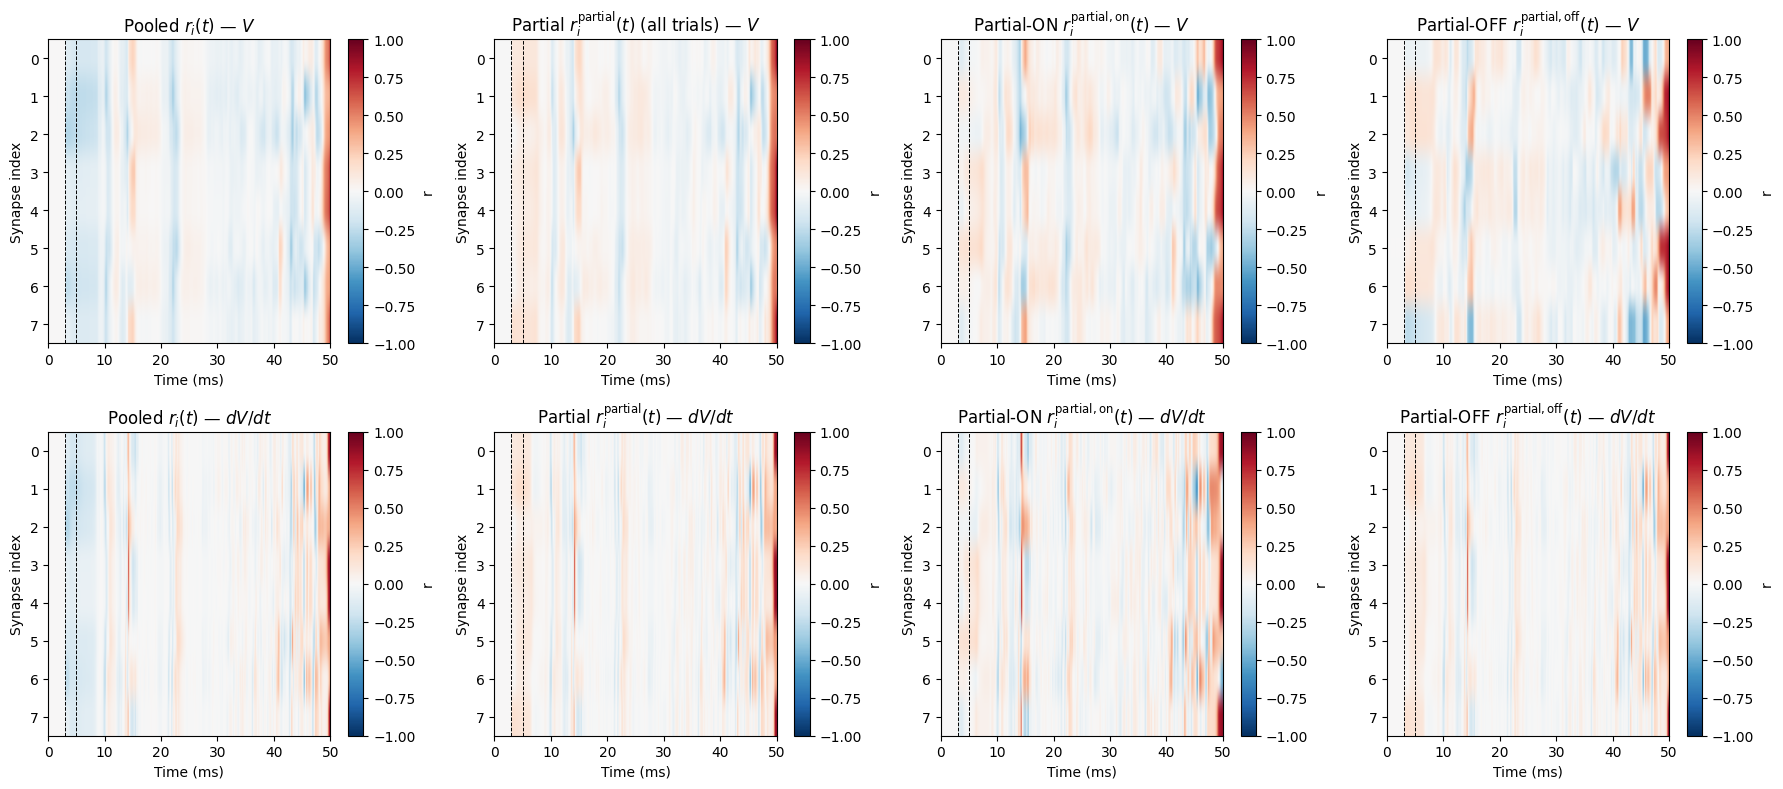

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))

# V
titles_top = [
    r"Pooled $r_i(t)$",
    r"Partial $r_i^{\mathrm{partial}}(t)$ (all trials)",
    r"Partial-ON $r_i^{\mathrm{partial,on}}(t)$",
    r"Partial-OFF $r_i^{\mathrm{partial,off}}(t)$",
]
datas_top = [r_v_all, r_partial, r_partial_on, r_partial_off]

for ax, data, title in zip(axes[0], datas_top, titles_top):
    im = ax.imshow(
        data, aspect="auto", cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, -0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title + " — $V$")
    plt.colorbar(im, ax=ax, label="r")

# dVdt
titles_bot = [
    r"Pooled $r_i(t)$",
    r"Partial $r_i^{\mathrm{partial}}(t)$",
    r"Partial-ON $r_i^{\mathrm{partial,on}}(t)$",
    r"Partial-OFF $r_i^{\mathrm{partial,off}}(t)$",
]
datas_bot = [r_dvdt, r_partial_dvdt, r_partial_on_dvdt, r_partial_off_dvdt]

for ax, data, title in zip(axes[1], datas_bot, titles_bot):
    im = ax.imshow(
        data, aspect="auto", cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, -0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title + " — $dV/dt$")
    plt.colorbar(im, ax=ax, label="r")

plt.tight_layout()
plt.show()


## "Is it real?" — Permutation test

Shuffle `GRADS[:, i]` across trials (within ON group for conditional analyses), recompute peak $r^2$ in the stimulus window, and build a null distribution.  Report p-values per synapse for:
- Pooled
- Conditional ON
- Partial (all trials)
- Partial ON


In [ ]:
# ── Permutation test ──
def peak_r2_stim(r_mat, t_stim):
    """Max r² within stimulus window for each synapse."""
    return np.nanmax(r_mat[:, t_stim]**2, axis=1)   # (Nsyn,)


def permutation_test(VALL, GRADS, patterns, t_stim,
                     n_perm=1000, seed=42, min_trials=20):
    """
    Permutation test for peak r² in stimulus window.

    For each permutation, shuffle GRADS[:, i] independently for each synapse,
    then recompute pooled, conditional-ON, partial, and partial-ON correlations.
    Returns observed peak r² and p-values for each analysis.
    """
    rng = np.random.default_rng(seed)
    N, Nsyn, T = VALL.shape

    # ── Observed peak r² ──
    obs_pooled     = peak_r2_stim(r_v_all, t_stim)       # uses pre-computed
    obs_on         = peak_r2_stim(r_on, t_stim)
    obs_partial    = peak_r2_stim(r_partial, t_stim)
    obs_partial_on = peak_r2_stim(r_partial_on, t_stim)

    # ── Null distributions ──
    null_pooled     = np.zeros((n_perm, Nsyn))
    null_on         = np.zeros((n_perm, Nsyn))
    null_partial    = np.zeros((n_perm, Nsyn))
    null_partial_on = np.zeros((n_perm, Nsyn))

    # Design matrix for partial (all trials)
    P_all = np.concatenate([np.ones((N, 1)), patterns.astype(float)], axis=1)

    for p in range(n_perm):
        if (p + 1) % 200 == 0:
            print(f"  permutation {p+1}/{n_perm}")

        # Shuffle GRADS independently per synapse
        GRADS_shuf = GRADS.copy()
        for i in range(Nsyn):
            rng.shuffle(GRADS_shuf[:, i])

        for i in range(Nsyn):
            g_s = GRADS_shuf[:, i]

            # --- pooled ---
            X = VALL[:, i, t_stim]   # (N, T_stim)
            X_dm = X - X.mean(axis=0, keepdims=True)
            g_dm = g_s - g_s.mean()
            num   = (X_dm * g_dm[:, None]).sum(axis=0)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (g_dm**2).sum()) + 1e-12
            null_pooled[p, i] = np.max((num / denom)**2)

            # --- conditional ON ---
            m_on = patterns[:, i].astype(bool)
            if m_on.sum() >= min_trials:
                y = g_s[m_on]
                X2 = VALL[m_on, i][:, t_stim]
                X2_dm = X2 - X2.mean(axis=0, keepdims=True)
                y_dm  = y - y.mean()
                num   = (X2_dm * y_dm[:, None]).sum(axis=0)
                denom = np.sqrt((X2_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
                null_on[p, i] = np.max((num / denom)**2)

            # --- partial (all trials) ---
            y_res = residualize_against_P(g_s.astype(float), P_all)
            X_res = residualize_against_P(VALL[:, i, t_stim].astype(float), P_all)
            X_dm = X_res - X_res.mean(axis=0, keepdims=True)
            y_dm = y_res - y_res.mean()
            num   = (X_dm * y_dm[:, None]).sum(axis=0)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
            null_partial[p, i] = np.max((num / denom)**2)

            # --- partial ON ---
            if m_on.sum() >= min_trials:
              n_on = m_on.sum()
              P_on = np.concatenate(
                  [np.ones((n_on, 1)), patterns[m_on].astype(float)], axis=1
              )
              y_res = residualize_against_P(g_s[m_on].astype(float), P_on)
              X_res = residualize_against_P(VALL[m_on, i][:, t_stim].astype(float), P_on)
              X_dm = X_res - X_res.mean(axis=0, keepdims=True)
              y_dm = y_res - y_res.mean()
              num   = (X_dm * y_dm[:, None]).sum(axis=0)
              denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
              null_partial_on[p, i] = np.max((num / denom)**2)


    # ── p-values: fraction of null ≥ observed ──
    pval_pooled     = ((null_pooled     >= obs_pooled[None, :]).sum(axis=0) + 1) / (n_perm + 1)
    pval_on         = ((null_on         >= obs_on[None, :]).sum(axis=0) + 1)     / (n_perm + 1)
    pval_partial    = ((null_partial    >= obs_partial[None, :]).sum(axis=0) + 1) / (n_perm + 1)
    pval_partial_on = ((null_partial_on >= obs_partial_on[None, :]).sum(axis=0) + 1) / (n_perm + 1)

    return dict(
        obs_pooled=obs_pooled, obs_on=obs_on,
        obs_partial=obs_partial, obs_partial_on=obs_partial_on,
        pval_pooled=pval_pooled, pval_on=pval_on,
        pval_partial=pval_partial, pval_partial_on=pval_partial_on,
    )


print("Running permutation test (n_perm=1000) ...")
perm = permutation_test(VALL, GRADS, patterns, t_stim, n_perm=1000)
print("Done!")


Running permutation test (n_perm=1000) ...
  permutation 200/1000
  permutation 400/1000
  permutation 600/1000
  permutation 800/1000
  permutation 1000/1000
Done!


In [ ]:
# ── Display permutation test results ──
print("=" * 72)
print(f"{'Synapse':>8}  {'Pooled r²':>10} {'p':>7}  {'ON r²':>10} {'p':>7}  "
      f"{'Partial r²':>11} {'p':>7}  {'Part-ON r²':>11} {'p':>7}")
print("-" * 72)
for i in range(Nsyn):
    print(f"{i:>8d}  "
          f"{perm['obs_pooled'][i]:10.4f} {perm['pval_pooled'][i]:7.4f}  "
          f"{perm['obs_on'][i]:10.4f} {perm['pval_on'][i]:7.4f}  "
          f"{perm['obs_partial'][i]:11.4f} {perm['pval_partial'][i]:7.4f}  "
          f"{perm['obs_partial_on'][i]:11.4f} {perm['pval_partial_on'][i]:7.4f}")
print("=" * 72)
print("\np < 0.05 indicates that peak r² in the stimulus window is")
print("unlikely under the null (shuffled gradients).")


 Synapse   Pooled r²       p       ON r²       p   Partial r²       p   Part-ON r²       p
------------------------------------------------------------------------
       0      0.0012  0.5654      0.0040  0.4096       0.0007  0.6723       0.0021  0.5984
       1      0.0017  0.5415      0.0039  0.3966       0.0031  0.2527       0.0211  0.0470
       2      0.0051  0.2108      0.0161  0.0599       0.0104  0.0519       0.0023  0.7253
       3      0.0300  0.0010      0.0185  0.0430       0.0216  0.0030       0.0587  0.0010
       4      0.0441  0.0010      0.0919  0.0010       0.0644  0.0010       0.0120  0.1628
       5      0.0050  0.1718      0.0693  0.0010       0.0459  0.0010       0.0390  0.0050
       6      0.0183  0.0030      0.0348  0.0020       0.0488  0.0010       0.1194  0.0010
       7      0.0293  0.0010      0.0381  0.0030       0.0346  0.0010       0.0286  0.0120

p < 0.05 indicates that peak r² in the stimulus window is
unlikely under the null (shuffled gradients).


In [ ]:
# ── Save all results ──
save_B = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "analysis_cond_partial.npz")
np.savez(
    save_B,
    # Part A: conditional
    r_on=r_on, r_off=r_off,
    r_on_dvdt=r_on_dvdt, r_off_dvdt=r_off_dvdt,
    on_counts=on_counts, off_counts=off_counts,
    # Part B: partial
    r_partial=r_partial, r_partial_hw=r_partial_hw,
    r_partial_on=r_partial_on,
    r_partial_dvdt=r_partial_dvdt,
    r_partial_on_dvdt=r_partial_on_dvdt,
    # Permutation p-values
    perm_obs_pooled=perm["obs_pooled"],
    perm_obs_on=perm["obs_on"],
    perm_obs_partial=perm["obs_partial"],
    perm_obs_partial_on=perm["obs_partial_on"],
    perm_pval_pooled=perm["pval_pooled"],
    perm_pval_on=perm["pval_on"],
    perm_pval_partial=perm["pval_partial"],
    perm_pval_partial_on=perm["pval_partial_on"],
    # Metadata
    t=t,
)
print(f"✓ Saved → {save_B}  ({os.path.getsize(save_B)/1e3:.1f} kB)")


## Step 1 — Full cross-correlation matrix $R_{i,j}(t)$

$$R_{i,j}(t) = \operatorname{corr}_{\text{trials}}\!\big(V_j(t),\; g_i\big)$$

- If credit is **local**: $R_{i,i}(t)$ should dominate off-diagonals.
- If it's **global**: vertical structure across many $j$'s for a fixed $i$.


In [ ]:
# ── Cross-correlation matrix (vectorised via einsum) ──
def crosscorr_time(VALL, GRADS, eps=1e-12):
    """
    Full cross-correlation matrix R_{i,j}(t) = corr_trials(V_j(t), g_i).

    VALL  : (N, J, T) — voltage traces
    GRADS : (N, I)    — scalar gradients
    Returns R : (I, J, T)
    """
    N, J, T = VALL.shape
    I = GRADS.shape[1]

    Y = GRADS - GRADS.mean(axis=0, keepdims=True)    # (N, I)
    X = VALL  - VALL.mean(axis=0, keepdims=True)      # (N, J, T)

    num = np.einsum("ni,njt->ijt", Y, X)              # (I, J, T)
    sy  = np.sqrt((Y**2).sum(axis=0)) + eps           # (I,)
    sx  = np.sqrt((X**2).sum(axis=0)) + eps           # (J, T)

    R = num / (sy[:, None, None] * sx[None, :, :])    # (I, J, T)
    return R


R_cross = crosscorr_time(VALL, GRADS)
print(f"R_cross shape: {R_cross.shape}")  # (8, 8, 2002)

# Also for dV/dt
R_cross_dvdt = crosscorr_time(dVdt, GRADS)
print(f"R_cross_dvdt shape: {R_cross_dvdt.shape}")


In [ ]:
# ── Diagonal / off-diagonal summary ──
def diag_off_summary(R):
    """
    Separate diagonal r² from off-diagonal r² across time.

    R : (I, J, T) with I == J
    Returns diag_m, off_m, ratio — all shape (T,)
    """
    I, J, T = R.shape
    assert I == J, "R must be square in first two dims"

    diag = np.array([R[i, i, :] for i in range(I)])       # (I, T)
    flat = R.reshape(I * J, T)
    off_mask = np.ones(I * J, dtype=bool)
    off_mask[np.arange(I) * J + np.arange(I)] = False
    off = flat[off_mask]                                   # (I*J - I, T)

    diag_m = (diag**2).mean(axis=0)                        # (T,)
    off_m  = (off**2).mean(axis=0)                         # (T,)
    ratio  = diag_m / (off_m + 1e-12)
    return diag_m, off_m, ratio


diag_m, off_m, ratio = diag_off_summary(R_cross)
diag_m_dv, off_m_dv, ratio_dv = diag_off_summary(R_cross_dvdt)

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
ax.plot(t, diag_m,  label=r"diagonal $\overline{r_{ii}^2}$", lw=1.5)
ax.plot(t, off_m,   label=r"off-diag $\overline{r_{i \neq j}^2}$", lw=1.5)
ax.set_ylabel(r"mean $r^2$")
ax.set_title("Cross-matrix: diagonal vs off-diagonal  (Voltage)")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
ax.plot(t, ratio,    label=r"$V$", lw=1.5)
ax.plot(t, ratio_dv, label=r"$dV/dt$", lw=1.5, ls="--")
ax.axhline(1, color="grey", lw=0.5, ls=":")
ax.set_ylabel("ratio  (diagonal / off-diagonal)")
ax.set_xlabel("Time (ms)")
ax.set_title("Diagonal dominance ratio")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


In [ ]:
# ── Heatmap snapshots of R_{i,j} at key timepoints + stimulus-window average ──
# Pick a few representative timepoints
t_snap_ms = [i_delay, i_delay + i_dur / 2, i_delay + i_dur, i_delay + i_dur + 2]
t_snap_idx = [np.argmin(np.abs(t - ts)) for ts in t_snap_ms]

# Stimulus-window average
R_stim_avg = R_cross[:, :, t_stim].mean(axis=2)   # (I, J)

n_panels = len(t_snap_idx) + 1  # snapshots + stim average
fig, axes = plt.subplots(1, n_panels, figsize=(4 * n_panels, 3.5))

vmax = np.max(np.abs(R_cross[:, :, t_stim]))  # adaptive color scale

for k, (ax, tidx) in enumerate(zip(axes[:-1], t_snap_idx)):
    im = ax.imshow(R_cross[:, :, tidx], cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    ax.set_title(f"t = {t[tidx]:.2f} ms")
    ax.set_xlabel("Voltage synapse $j$")
    ax.set_ylabel("Gradient synapse $i$")
    # highlight diagonal
    for d in range(Nsyn):
        ax.add_patch(plt.Rectangle((d - 0.5, d - 0.5), 1, 1,
                                    fill=False, ec="k", lw=1.5))

# Stimulus-window average
ax = axes[-1]
im = ax.imshow(R_stim_avg, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
ax.set_title(f"stim avg ({i_delay}–{i_delay+i_dur} ms)")
ax.set_xlabel("Voltage synapse $j$")
ax.set_ylabel("Gradient synapse $i$")
for d in range(Nsyn):
    ax.add_patch(plt.Rectangle((d - 0.5, d - 0.5), 1, 1,
                                fill=False, ec="k", lw=1.5))

plt.colorbar(im, ax=axes.tolist(), label="Pearson r", shrink=0.8)
fig.suptitle(r"$R_{i,j}(t)$ — pooled cross-correlation", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


## Step 2 — Partial-ON cross-correlation matrix $R_{i,j}^{\text{partial,on}}(t)$

For each gradient synapse $i$:
1. Restrict to ON trials for synapse $i$
2. Residualize $g_i$ and every $V_j(t)$ against pattern bits
3. Compute $R_{i,j}^{\text{partial,on}}(t) = \operatorname{corr}(\text{resid}(V_j(t)),\; \text{resid}(g_i))$

This is the strongest test: does **local** voltage at synapse $j$ explain the gradient at synapse $i$, within ON trials and beyond pattern context?


In [ ]:
# ── Partial-ON cross-correlation matrix ──
def crosscorr_partial_on(VALL, GRADS, patterns, min_trials=20, eps=1e-12):
    """
    Partial-ON cross-correlation matrix R_{i,j}^{partial,on}(t).

    For each gradient synapse i:
      - restrict to ON trials for synapse i
      - build design matrix P = [1, patterns] (from those trials)
      - residualize g_i and every V_j(t) against P
      - correlate residuals

    Returns R_partial_on : (I, J, T)
    """
    N, J, T = VALL.shape
    I = GRADS.shape[1]
    R_partial_on = np.full((I, J, T), np.nan)

    for i in range(I):
        m = patterns[:, i].astype(bool)
        n_on = m.sum()
        if n_on < min_trials:
            print(f"  gradient synapse {i}: skipped ({n_on} ON trials)")
            continue

        # Design matrix: intercept + other pattern bits
        mask_other = np.ones(I, dtype=bool)
        mask_other[i] = False
        P = np.concatenate([
            np.ones((n_on, 1)),
            patterns[m][:, mask_other].astype(float)
        ], axis=1)  # (n_on, 1 + (Nsyn-1))

        # Residualize gradient
        y_res = residualize_against_P(GRADS[m, i].astype(float), P)  # (n_on,)
        y_dm  = y_res - y_res.mean()

        for j in range(J):
            # Residualize voltage at synapse j
            X_res = residualize_against_P(VALL[m, j, :].astype(float), P)  # (n_on, T)
            X_dm  = X_res - X_res.mean(axis=0, keepdims=True)

            num   = (X_dm * y_dm[:, None]).sum(axis=0)                     # (T,)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + eps
            R_partial_on[i, j, :] = num / denom

    return R_partial_on


R_partial_on_cross = crosscorr_partial_on(VALL, GRADS, patterns)
print(f"R_partial_on_cross shape: {R_partial_on_cross.shape}")  # (8, 8, 2002)


In [ ]:
# ── Heatmap snapshots: pooled vs partial-ON cross-matrix ──
R_po_stim_avg = np.nanmean(R_partial_on_cross[:, :, t_stim], axis=2)  # (I, J)

fig, axes = plt.subplots(1, 2, figsize=(9, 3.8))

vmax2 = max(np.nanmax(np.abs(R_stim_avg)),
            np.nanmax(np.abs(R_po_stim_avg)))

for ax, mat, title in zip(
    axes,
    [R_stim_avg, R_po_stim_avg],
    [r"Pooled $R_{i,j}$ (stim avg)",
     r"Partial-ON $R_{i,j}^{\mathrm{partial,on}}$ (stim avg)"],
):
    im = ax.imshow(mat, cmap="RdBu_r", vmin=-vmax2, vmax=vmax2)
    ax.set_xlabel("Voltage synapse $j$")
    ax.set_ylabel("Gradient synapse $i$")
    ax.set_title(title)
    for d in range(Nsyn):
        ax.add_patch(plt.Rectangle((d - 0.5, d - 0.5), 1, 1,
                                    fill=False, ec="k", lw=1.5))

plt.colorbar(im, ax=axes.tolist(), label="Pearson r", shrink=0.8)
plt.tight_layout()
plt.show()


In [ ]:
# ── Diagonal dominance: pooled vs partial-ON ──
diag_po, off_po, ratio_po = diag_off_summary(
    np.nan_to_num(R_partial_on_cross, nan=0.0)
)

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
ax.plot(t, diag_m,  label=r"Pooled diag $\overline{r_{ii}^2}$",       lw=1.5)
ax.plot(t, off_m,   label=r"Pooled off-diag $\overline{r_{i\neq j}^2}$", lw=1.5)
ax.plot(t, diag_po, label=r"Partial-ON diag",   lw=1.5, ls="--")
ax.plot(t, off_po,  label=r"Partial-ON off-diag", lw=1.5, ls="--")
ax.set_ylabel(r"mean $r^2$")
ax.set_title("Cross-matrix diagonal vs off-diagonal: pooled vs partial-ON")
ax.legend(fontsize=8, ncol=2)
ax.set_ylim(bottom=0)

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
ax.plot(t, ratio,    label="Pooled ratio", lw=1.5)
ax.plot(t, ratio_po, label="Partial-ON ratio", lw=1.5, ls="--")
ax.axhline(1, color="grey", lw=0.5, ls=":")
ax.set_ylabel("ratio  (diag / off-diag)")
ax.set_xlabel("Time (ms)")
ax.set_title("Diagonal dominance ratio comparison")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


## Step 3 — Windowed effect-size metrics

Replace "max $r^2$" with more stable windowed metrics in the stimulus window:
- **Mean $r^2$** in stimulus window
- **AUC** (area under the $r^2(t)$ curve) in stimulus window

These are less sensitive to a single noisy time bin.


In [ ]:
# ── Windowed effect-size metrics ──
def windowed_metrics(r_mat, t_stim, dt):
    """
    Compute mean r² and AUC(r²) in stimulus window per synapse.

    r_mat   : (Nsyn, T)
    t_stim  : bool mask (T,)
    dt      : timestep in ms
    Returns mean_r2 (Nsyn,), auc_r2 (Nsyn,)
    """
    r2_stim = r_mat[:, t_stim]**2                    # (Nsyn, T_stim)
    mean_r2 = np.nanmean(r2_stim, axis=1)            # (Nsyn,)
    auc_r2  = np.nansum(r2_stim, axis=1) * dt        # (Nsyn,)  [ms·r²]
    return mean_r2, auc_r2


# Compute for all analysis variants
metrics = {}
for name, r_mat in [
    ("pooled",       r_v_all),
    ("cond_ON",      r_on),
    ("cond_OFF",     r_off),
    ("partial",      r_partial),
    ("partial_on",   r_partial_on),
]:
    m_r2, a_r2 = windowed_metrics(r_mat, t_stim, dt)
    metrics[name] = {"mean_r2": m_r2, "auc_r2": a_r2}

# Also for diagonal / off-diagonal of cross-matrix
diag_cross = np.array([R_cross[i, i, :] for i in range(Nsyn)])         # (Nsyn, T)
off_cross  = np.nanmean(np.array([
    [R_cross[i, j, :] for j in range(Nsyn) if j != i]
    for i in range(Nsyn)
]), axis=1)  # (Nsyn, T) — mean off-diagonal per gradient synapse

m_diag, a_diag = windowed_metrics(diag_cross, t_stim, dt)
m_off,  a_off  = windowed_metrics(off_cross,  t_stim, dt)
metrics["cross_diag"]    = {"mean_r2": m_diag, "auc_r2": a_diag}
metrics["cross_offdiag"] = {"mean_r2": m_off,  "auc_r2": a_off}

# ── Print summary table ──
print("=" * 90)
print(f"{'Analysis':<16} | {'Synapse':<8} | {'max r²':>8} | {'mean r²':>9} | {'AUC r²':>10}")
print("-" * 90)
for name in ["pooled", "cond_ON", "partial", "partial_on", "cross_diag", "cross_offdiag"]:
    r_mat_lookup = {
        "pooled": r_v_all, "cond_ON": r_on, "partial": r_partial,
        "partial_on": r_partial_on, "cross_diag": diag_cross,
        "cross_offdiag": off_cross,
    }
    for i in range(Nsyn):
        peak = np.nanmax(r_mat_lookup[name][i, t_stim]**2)
        mr2  = metrics[name]["mean_r2"][i]
        auc  = metrics[name]["auc_r2"][i]
        syn_label = f"  syn {i}" if i > 0 else f"  syn {i}"
        prefix = f"{name:<16}" if i == 0 else f"{'':16}"
        print(f"{prefix} | {syn_label:<8} | {peak:8.4f} | {mr2:9.4f} | {auc:10.4f}")
    print("-" * 90)
print("=" * 90)


In [ ]:
# ── Bar chart: mean r² in stimulus window across analyses ──
analysis_names = ["pooled", "cond_ON", "partial", "partial_on"]
colors = plt.cm.Set2(np.linspace(0, 1, len(analysis_names)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- per-synapse mean r² ---
ax = axes[0]
x = np.arange(Nsyn)
width = 0.18
for k, name in enumerate(analysis_names):
    vals = metrics[name]["mean_r2"]
    ax.bar(x + k * width, vals, width, label=name, color=colors[k])
ax.set_xticks(x + width * (len(analysis_names) - 1) / 2)
ax.set_xticklabels([f"syn {i}" for i in range(Nsyn)])
ax.set_ylabel(r"mean $r^2$ (stim window)")
ax.set_title("Effect size per synapse: mean $r^2$")
ax.legend(fontsize=8)

# --- cross-matrix diag vs off-diag ---
ax = axes[1]
ax.bar(x - 0.15, metrics["cross_diag"]["mean_r2"],    0.3,
       label="diagonal (local)", color="steelblue")
ax.bar(x + 0.15, metrics["cross_offdiag"]["mean_r2"], 0.3,
       label="off-diagonal (non-local)", color="salmon")
ax.set_xticks(x)
ax.set_xticklabels([f"syn {i}" for i in range(Nsyn)])
ax.set_ylabel(r"mean $r^2$ (stim window)")
ax.set_title("Cross-matrix: local vs non-local credit")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# ── Save cross-matrix + windowed metrics ──
save_C = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "analysis_cross_windowed.npz")

# Flatten metrics dict for saving
metrics_flat = {}
for name, d in metrics.items():
    for k, v in d.items():
        metrics_flat[f"metric_{name}_{k}"] = v

np.savez(
    save_C,
    # Step 1: pooled cross-matrix
    R_cross=R_cross,                   # (I, J, T)
    R_cross_dvdt=R_cross_dvdt,
    R_stim_avg=R_stim_avg,             # (I, J)
    diag_m=diag_m, off_m=off_m, ratio=ratio,   # (T,) each
    # Step 2: partial-ON cross-matrix
    R_partial_on_cross=R_partial_on_cross,      # (I, J, T)
    R_po_stim_avg=R_po_stim_avg,                # (I, J)
    diag_po=diag_po, off_po=off_po, ratio_po=ratio_po,
    # Step 3: windowed metrics
    **metrics_flat,
    # Metadata
    t=t,
)
print(f"✓ Saved → {save_C}  ({os.path.getsize(save_C)/1e6:.1f} MB)")
